# Importação de bibliotecas

In [43]:
from copy import deepcopy
import os
import pickle
import sys
from tqdm import tqdm
import numpy as np
import scipy.io as io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Manipulação dos dados

## Abrindo o diretório


In [2]:
path='F:\FACUL\FACULDADE\PG1\Dados'
os.listdir(path)
Df_v1 = pd.read_csv(f'{path}\\sensor.csv')

## Obtendo o Dataframe

In [3]:
Df_v2 = Df_v1.drop(columns='Unnamed: 0') #Coluna repete index
Df_v2 = Df_v2.drop(columns='sensor_15') #Coluna inexistente
# Df_v2.loc('SENSOR_04')
Cols=Df_v2.columns

In [4]:
Df_v2.info

<bound method DataFrame.info of                   timestamp  sensor_00  sensor_01  sensor_02  sensor_03  \
0       2018-04-01 00:00:00   2.465394   47.09201  53.211800  46.310760   
1       2018-04-01 00:01:00   2.465394   47.09201  53.211800  46.310760   
2       2018-04-01 00:02:00   2.444734   47.35243  53.211800  46.397570   
3       2018-04-01 00:03:00   2.460474   47.09201  53.168400  46.397568   
4       2018-04-01 00:04:00   2.445718   47.13541  53.211800  46.397568   
...                     ...        ...        ...        ...        ...   
220315  2018-08-31 23:55:00   2.407350   47.69965  50.520830  43.142361   
220316  2018-08-31 23:56:00   2.400463   47.69965  50.564240  43.142361   
220317  2018-08-31 23:57:00   2.396528   47.69965  50.520830  43.142361   
220318  2018-08-31 23:58:00   2.406366   47.69965  50.520832  43.142361   
220319  2018-08-31 23:59:00   2.396528   47.69965  50.520832  43.142361   

         sensor_04  sensor_05  sensor_06  sensor_07  sensor_08  ...

In [5]:
# df2 = Df_v2['sensor_00']
# df.append(df2)
Cols

Index(['timestamp', 'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03',
       'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08',
       'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19',
       'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24',
       'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29',
       'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34',
       'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39',
       'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44',
       'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49',
       'sensor_50', 'sensor_51', 'machine_status'],
      dtype='object')

In [6]:
for x in range(40,48):
    df=[]
    df2 = Df_v2[Cols[x]]
    df.append(df2)
    # k=k+1

In [14]:
# Df_v2[Cols[3]].iloc[25112]
# Df_v2[Cols[2]][2]
Df_v3=Df_v2.fillna(method ='pad')
# Df_v2.replace(to_replace = np.nan, value = -99) 

In [15]:
Df_v3.isnull().sum()
Df_v2[Cols[3]].loc[Df_v2[Cols[3]].isnull()]


# for Title in Cols:
    # for Value in range(len(Df_v2[Title])):
    #     if Df_v2[Title][Value] == 'NaN' :
    #         Df_v2[Title][Value].interpolate(method ='linear', limit_direction ='forward')
    
    # if Df_v2[Title].isnull().sum() > 0 :
    #    ContNull = Df_v2[Title].isnull().sum()
    #     for id in range(ContNull):
    #         Df_v2[Title].loc[Df_v2[Title].isnull()]

timestamp         0
sensor_00         0
sensor_01         0
sensor_02         0
sensor_03         0
sensor_04         0
sensor_05         0
sensor_06         0
sensor_07         0
sensor_08         0
sensor_09         0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
sensor_20         0
sensor_21         0
sensor_22         0
sensor_23         0
sensor_24         0
sensor_25         0
sensor_26         0
sensor_27         0
sensor_28         0
sensor_29         0
sensor_30         0
sensor_31         0
sensor_32         0
sensor_33         0
sensor_34         0
sensor_35         0
sensor_36         0
sensor_37         0
sensor_38         0
sensor_39         0
sensor_40         0
sensor_41         0
sensor_42         0
sensor_43         0
sensor_44         0
sensor_45         0
sensor_46         0
sensor_47         0
sensor_48         0
sensor_49         0


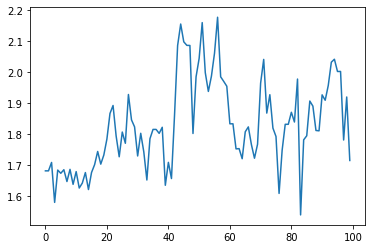

In [21]:
# Df_v2[Cols[1]].loc[Df_v2[Cols[1]].isnull()]
# Df_v2[Cols[1]].iloc[17157]

pyplot.plot(Df_v3['sensor_13'][:100])


<AxesSubplot:>

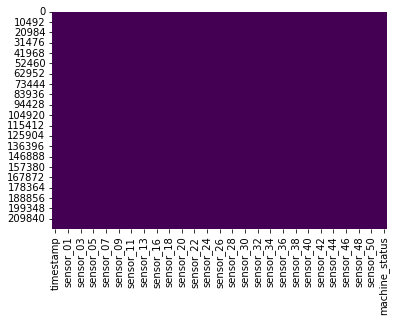

In [16]:
sns.heatmap(Df_v3.isnull(),cbar=False,cmap='viridis')

In [22]:
# Cols[47]
len(Df_v3.values[1])
# Cols[1].split('_')
Cols[51][-2:]

'51'

In [10]:
# Df_v2[Cols[1]]
# sensor
Cols

Index(['timestamp', 'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03',
       'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08',
       'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19',
       'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24',
       'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29',
       'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34',
       'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39',
       'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44',
       'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49',
       'sensor_50', 'sensor_51', 'machine_status'],
      dtype='object')

## Transformando em .Parquet

In [41]:
# os.makedirs('accel_data/', exist_ok=True)

# prefix = path.split('/')[-1] #Prefixo do nome a ser salvo no arquivo. EX. "LRV4306_acc.parquet"
Df_v3.to_parquet('F:\FACUL\FACULDADE\PG1\Dados\Dados_Pump.parquet', index=False)

## Separando os sensores

In [100]:
Df_bearingTemp=pd.DataFrame()
Df_vibration=pd.DataFrame()
Df_motorProprieties=pd.DataFrame()
Df_pumpSpeed=pd.DataFrame()
Df_pumpFlow=pd.DataFrame()
Df_pumpLube=pd.DataFrame()
Df_pumpPressure=pd.DataFrame()


In [103]:
# Df_v2.unique()
k=0
# Df_v2.loc[Df_v2['sensor_00']]
# Df_v2.isna().describe()
Df_final = pd.read_parquet(path+r'\Dados_Pump.parquet')
for column in tqdm(Cols):
    if column == 'timestamp' or column == 'machine_status':
        pass
    else:
        name_var = column.split('_')
        name_var = name_var[1]
        # try:
        if name_var >= '01' and name_var <= '12' or name_var >= '14' and name_var <= '17':
            Df_motorProprieties[f'sensor_{name_var}'] = Df_final[f'sensor_{name_var}']

        if name_var == '00' or name_var == '13' or name_var == '18':
            Df_vibration[f'sensor_{name_var}'] = Df_final[f'sensor_{name_var}']

        if name_var >= '19' and name_var <= '33':
            Df_pumpSpeed[f'sensor_{name_var}'] = Df_final[f'sensor_{name_var}']

        if name_var >= '34' and name_var <= '36':
            Df_pumpFlow[f'sensor_{name_var}'] = Df_final[f'sensor_{name_var}']

        if name_var >= '37' and name_var <= '39':
            Df_pumpLube[f'sensor_{name_var}'] = Df_final[f'sensor_{name_var}']

        if name_var >= '40' and name_var <= '47':
            Df_bearingTemp[f'sensor_{name_var}'] = Df_final[f'sensor_{name_var}']

        if name_var >= '48' and name_var <= '51':
            Df_pumpPressure[f'sensor_{name_var}'] = Df_final[f'sensor_{name_var}']

100%|██████████| 53/53 [00:00<00:00, 291.22it/s]


In [104]:

Df_motorProprieties.rename({'sensor_01':'Motor Frequency A','sensor_02':'Motor Frequency B','sensor_03':'Motor Frequency C',
'sensor_04':'Motor Speed','sensor_05':'Motor Current','sensor_06':'Motor Active Power','sensor_07':'Motor Apparent Power','sensor_08':'Motor Reactive Power',
'sensor_09':'Motor Shaft Power','sensor_10':'Motor Phase Current A','sensor_11':'Motor Phase Current B','sensor_12':'Motor Phase Current C','sensor_14':'Motor Phase Voltage AB',
'sensor_16':'Motor Phase Voltage BC','sensor_17':'Motor Phase Voltage CA'},axis=1,inplace=True)

Df_motorProprieties.head()

# SENSOR_01 - Motor Frequency A
# SENSOR_02 - Motor Frequency B
# SENSOR_03 - Motor Frequency C
# SENSOR_04 - Motor Speed
# SENSOR_05 - Motor Current
# SENSOR_06 - Motor Active Power
# SENSOR_07 - Motor Apparent Power
# SENSOR_08 - Motor Reactive Power
# SENSOR_09 - Motor Shaft Power  
# SENSOR_10 - Motor Phase Current A
# SENSOR_11 - Motor Phase Current B
# SENSOR_12 - Motor Phase Current C
# SENSOR_14 - Motor Phase Voltage AB
# SENSOR_16 - Motor Phase Voltage BC
# SENSOR_17 - Motor Phase Voltage CA

,Motor Frequency A,Motor Frequency B,Motor Frequency C,Motor Speed,Motor Current,Motor Active Power,Motor Apparent Power,Motor Reactive Power,Motor Shaft Power,Motor Phase Current A,Motor Phase Current B,Motor Phase Current C,Motor Phase Voltage AB,Motor Phase Voltage BC,Motor Phase Voltage CA
0,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,419.5747,461.8781,466.3284
1,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,419.5747,461.8781,466.3284
2,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,420.8480,462.7798,459.6364
3,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,420.7494,462.8980,460.8858
4,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,419.8926,461.4906,468.2206


In [106]:
Df_vibration.rename({'sensor_00': 'Motor Casing Vibration', 'sensor_13':'Motor Coupling Vibration', 'sensor_18':'Pump Casing Vibration'},axis=1,inplace=True)

Df_vibration

# SENSOR_00 - Motor Casing Vibration
# SENSOR_13 - Motor Coupling Vibration
# SENSOR_18 - Pump Casing Vibration

,Motor Casing Vibration,Motor Coupling Vibration,Pump Casing Vibration
0,2.465394,1.681353,2.565284
1,2.465394,1.681353,2.565284
2,2.444734,1.708474,2.500062
3,2.460474,1.579427,2.509521
4,2.445718,1.683831,2.604785
...,...,...,...
220315,2.407350,13.265320,2.499117
220316,2.400463,13.242270,2.618476
220317,2.396528,13.188660,2.620500
220318,2.406366,13.173460,2.514596


In [107]:
Df_pumpSpeed.rename({'sensor_19': 'Pump Stage 1 Impeller Speed', 'sensor_20':'Pump Stage 1 Impeller Speed', 'sensor_21':'Pump Stage 1 Impeller Speed', 'sensor_22':'Pump Stage 1 Impeller Speed',
'sensor_23':'Pump Stage 1 Impeller Speed', 'sensor_24':'Pump Stage 1 Impeller Speed', 'sensor_25':'Pump Stage 2 Impeller Speed', 'sensor_26':'Pump Stage 2 Impeller Speed', 
'sensor_27':'Pump Stage 2 Impeller Speed', 'sensor_28':'Pump Stage 2 Impeller Speed', 'sensor_29':'Pump Stage 2 Impeller Speed', 'sensor_30':'Pump Stage 2 Impeller Speed',
'sensor_31':'Pump Stage 2 Impeller Speed', 'sensor_32':'Pump Stage 2 Impeller Speed', 'sensor_33':'Pump Stage 2 Impeller Speed'},axis=1,inplace=True)

Df_pumpSpeed.head()

# SENSOR_19 - Pump Stage 1 Impeller Speed
# SENSOR_20 - Pump Stage 1 Impeller Speed
# SENSOR_21 - Pump Stage 1 Impeller Speed
# SENSOR_22 - Pump Stage 1 Impeller Speed
# SENSOR_23 - Pump Stage 1 Impeller Speed
# SENSOR_24 - Pump Stage 1 Impeller Speed
# SENSOR_25 - Pump Stage 2 Impeller Speed
# SENSOR_26 - Pump Stage 2 Impeller Speed
# SENSOR_27 - Pump Stage 2 Impeller Speed
# SENSOR_28 - Pump Stage 2 Impeller Speed
# SENSOR_29 - Pump Stage 2 Impeller Speed
# SENSOR_30 - Pump Stage 2 Impeller Speed
# SENSOR_31 - Pump Stage 2 Impeller Speed
# SENSOR_32 - Pump Stage 2 Impeller Speed
# SENSOR_33 - Pump Stage 2 Impeller Speed

,Pump Stage 1 Impeller Speed,Pump Stage 1 Impeller Speed,Pump Stage 1 Impeller Speed,Pump Stage 1 Impeller Speed,Pump Stage 1 Impeller Speed,Pump Stage 1 Impeller Speed,Pump Stage 2 Impeller Speed,Pump Stage 2 Impeller Speed,Pump Stage 2 Impeller Speed,Pump Stage 2 Impeller Speed,Pump Stage 2 Impeller Speed,Pump Stage 2 Impeller Speed,Pump Stage 2 Impeller Speed,Pump Stage 2 Impeller Speed,Pump Stage 2 Impeller Speed
0,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037
1,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037
2,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635
3,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493
4,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081


In [108]:
Df_pumpFlow.rename({'sensor_34': 'Pump Inlet Flow', 'sensor_35':'Pump Discharge Flow', 'sensor_36':'Pump UNKNOWN'},axis=1,inplace=True)
Df_pumpFlow

# SENSOR_34 - Pump Inlet Flow
# SENSOR_35 - Pump Discharge Flow
# SENSOR_36 - Pump UNKNOWN

,Pump Inlet Flow,Pump Discharge Flow,Pump UNKNOWN
0,171.9375,341.9039,195.0655
1,171.9375,341.9039,195.0655
2,169.9820,343.1955,200.9694
3,166.4987,343.9586,193.1689
4,164.7498,339.9630,193.8770
...,...,...,...
220315,266.0334,578.5221,817.5707
220316,262.2222,568.1035,807.0151
220317,260.8372,553.8872,805.5605
220318,261.3184,559.4439,807.0808


In [109]:
Df_bearingTemp.rename({'sensor_40': 'Pump Thrust Bearing Active Temp', 'sensor_41':'Motor Non Drive End Radial Bearing Temp 1', 'sensor_42':'Motor Non Drive End Radial Bearing Temp 2',
'sensor_43':'Pump Thrust Bearing Inactive Temp','sensor_44':'Pump Drive End Radial Bearing Temp 1','sensor_45':'Pump non Drive End Radial Bearing Temp 1',
'sensor_46':'Pump non Drive End Radial Bearing Temp 2','sensor_47':'Pump Drive End Radial Bearing Temp 2'},axis=1,inplace=True)

Df_bearingTemp

# SENSOR_40 - Pump Thrust Bearing Active Temp
# SENSOR_41 - Motor Non Drive End Radial Bearing Temp 1
# SENSOR_42 - Motor Non Drive End Radial Bearing Temp 2
# SENSOR_43 - Pump Thrust Bearing Inactive Temp
# SENSOR_44 - Pump Drive End Radial Bearing Temp 1
# SENSOR_45 - Pump non Drive End Radial Bearing Temp 1
# SENSOR_46 - Pump Non Drive End Radial Bearing Temp 2
# SENSOR_47 - Pump Drive End Radial Bearing Temp 2

,Pump Thrust Bearing Active Temp,Motor Non Drive End Radial Bearing Temp 1,Motor Non Drive End Radial Bearing Temp 2,Pump Thrust Bearing Inactive Temp,Pump Drive End Radial Bearing Temp 1,Pump non Drive End Radial Bearing Temp 1,Pump non Drive End Radial Bearing Temp 2,Pump Drive End Radial Bearing Temp 2
0,70.57291,30.989580,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440
1,70.57291,30.989580,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440
2,69.53125,30.468750,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443
3,72.13541,30.468750,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440
4,76.82291,30.989580,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150
...,...,...,...,...,...,...,...,...
220315,71.61458,30.468750,30.208330,38.28125,68.287030,52.37268,48.32176,41.087960
220316,73.17708,30.208332,29.947920,38.28125,66.840280,50.63657,48.03241,40.798610
220317,77.08333,29.947920,30.208330,39.06250,65.393520,48.90046,48.03241,40.798610
220318,78.64583,29.947916,30.208332,40.62500,64.236110,47.74306,48.32176,40.509258


In [110]:
Df_pumpPressure.rename({'sensor_48': 'Pump Inlet Pressure', 'sensor_49':'Pump Temp Unknown', 'sensor_50':'Pump Discharge Pressure 1', 'sensor_51':'Pump Discharge Pressure 2'},axis=1,inplace=True)

Df_pumpPressure

# SENSOR_48 - Pump Inlet Pressure
# SENSOR_49 - Pump Temp Unknown
# SENSOR_50 - Pump Discharge Pressure 1
# SENSOR_51 - Pump Discharge Pressure 2

,Pump Inlet Pressure,Pump Temp Unknown,Pump Discharge Pressure 1,Pump Discharge Pressure 2
0,157.9861,67.70834,243.0556,201.3889
1,157.9861,67.70834,243.0556,201.3889
2,155.9606,67.12963,241.3194,203.7037
3,155.9606,66.84028,240.4514,203.1250
4,158.2755,66.55093,242.1875,201.3889
...,...,...,...,...
220315,212.3843,153.64580,1000.0000,231.1921
220316,213.8310,156.25000,1000.0000,231.1921
220317,217.3032,155.38190,1000.0000,232.0602
220318,222.5116,153.93520,1000.0000,234.0856


In [111]:
# SENSOR_00 - Motor Casing Vibration
# SENSOR_13 - Motor Coupling Vibration
# SENSOR_18 - Pump Casing Vibration

# SENSOR_01 - Motor Frequency A
# SENSOR_02 - Motor Frequency B
# SENSOR_03 - Motor Frequency C
# SENSOR_04 - Motor Speed
# SENSOR_05 - Motor Current
# SENSOR_06 - Motor Active Power
# SENSOR_07 - Motor Apparent Power
# SENSOR_08 - Motor Reactive Power
# SENSOR_09 - Motor Shaft Power  
# SENSOR_10 - Motor Phase Current A
# SENSOR_11 - Motor Phase Current B
# SENSOR_12 - Motor Phase Current C
# SENSOR_14 - Motor Phase Voltage AB
# SENSOR_16 - Motor Phase Voltage BC
# SENSOR_17 - Motor Phase Voltage CA



# SENSOR_19 - Pump Stage 1 Impeller Speed
# SENSOR_20 - Pump Stage 1 Impeller Speed
# SENSOR_21 - Pump Stage 1 Impeller Speed
# SENSOR_22 - Pump Stage 1 Impeller Speed
# SENSOR_23 - Pump Stage 1 Impeller Speed
# SENSOR_24 - Pump Stage 1 Impeller Speed
# SENSOR_25 - Pump Stage 2 Impeller Speed
# SENSOR_26 - Pump Stage 2 Impeller Speed
# SENSOR_27 - Pump Stage 2 Impeller Speed
# SENSOR_28 - Pump Stage 2 Impeller Speed
# SENSOR_29 - Pump Stage 2 Impeller Speed
# SENSOR_30 - Pump Stage 2 Impeller Speed
# SENSOR_31 - Pump Stage 2 Impeller Speed
# SENSOR_32 - Pump Stage 2 Impeller Speed
# SENSOR_33 - Pump Stage 2 Impeller Speed

# SENSOR_34 - Pump Inlet Flow
# SENSOR_35 - Pump Discharge Flow
# SENSOR_36 - Pump UNKNOWN

# SENSOR_37 - Pump Lube Oil Overhead Reservoir Level
# SENSOR_38 - Pump Lube Oil Return Temp
# SENSOR_39 - Pump Lube Oil Supply Temp

# SENSOR_40 - Pump Thrust Bearing Active Temp
# SENSOR_41 - Motor Non Drive End Radial Bearing Temp 1
# SENSOR_42 - Motor Non Drive End Radial Bearing Temp 2
# SENSOR_43 - Pump Thrust Bearing Inactive Temp
# SENSOR_44 - Pump Drive End Radial Bearing Temp 1
# SENSOR_45 - Pump non Drive End Radial Bearing Temp 1
# SENSOR_46 - Pump Non Drive End Radial Bearing Temp 2
# SENSOR_47 - Pump Drive End Radial Bearing Temp 2

# SENSOR_48 - Pump Inlet Pressure
# SENSOR_49 - Pump Temp Unknown
# SENSOR_50 - Pump Discharge Pressure 1
# SENSOR_51 - Pump Discharge Pressure 2
# Pump Status

## Correlação

In [112]:
# rs = np.random.RandomState(0)
# df = pd.DataFrame(rs.rand(10, 10))
corr = Df_v3.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

C:\Users\jorda\AppData\Local\Temp/ipykernel_3152/1271759825.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
sensor_00,1.00,0.63,0.80,0.65,0.95,0.43,0.82,0.75,0.73,0.69,0.92,0.87,0.81,0.28,-0.08,-0.08,-0.06,-0.05,-0.08,-0.07,-0.07,-0.07,-0.08,-0.08,-0.07,-0.06,-0.02,-0.20,-0.04,-0.11,-0.15,-0.12,-0.10,0.06,-0.08,0.01,-0.08,0.34,-0.01,0.37,0.09,-0.01,0.12,0.21,0.16,0.17,0.22,0.40,0.29,0.32,-0.19
sensor_01,0.63,1.00,0.74,0.69,0.68,0.16,0.69,0.68,0.67,0.67,0.60,0.57,0.51,0.20,0.03,0.03,0.03,0.03,0.03,0.03,0.04,0.02,0.01,0.02,0.03,-0.01,0.03,-0.10,0.04,-0.02,-0.07,-0.08,0.01,-0.02,-0.02,0.03,0.00,0.38,0.08,0.34,0.22,0.09,0.18,0.32,0.29,0.23,0.27,0.34,0.37,0.20,-0.14
sensor_02,0.80,0.74,1.00,0.82,0.82,0.26,0.79,0.77,0.74,0.75,0.76,0.71,0.69,0.19,-0.13,-0.13,-0.12,-0.10,-0.12,-0.12,-0.12,-0.12,-0.15,-0.14,-0.12,-0.13,-0.04,-0.22,0.01,-0.13,-0.17,-0.15,-0.10,-0.08,-0.19,-0.09,0.05,0.38,0.01,0.33,0.18,0.03,0.14,0.24,0.23,0.20,0.26,0.38,0.34,0.22,-0.20
sensor_03,0.65,0.69,0.82,1.00,0.68,0.15,0.71,0.68,0.65,0.66,0.62,0.67,0.61,0.33,-0.10,-0.10,-0.10,-0.09,-0.09,-0.09,-0.09,-0.08,-0.06,-0.11,-0.09,-0.08,0.06,-0.21,-0.08,-0.05,-0.11,-0.08,-0.09,0.02,-0.02,0.02,-0.09,0.36,0.02,0.36,0.19,0.04,0.17,0.31,0.25,0.23,0.27,0.46,0.37,0.43,-0.22
sensor_04,0.95,0.68,0.82,0.68,1.00,0.39,0.88,0.82,0.78,0.77,0.91,0.86,0.80,0.28,-0.07,-0.07,-0.06,-0.05,-0.07,-0.07,-0.06,-0.06,-0.07,-0.08,-0.06,-0.06,-0.02,-0.19,-0.03,-0.10,-0.14,-0.11,-0.09,0.05,-0.08,0.02,-0.08,0.36,0.00,0.38,0.13,0.00,0.14,0.22,0.16,0.17,0.23,0.39,0.30,0.31,-0.20
sensor_05,0.43,0.16,0.26,0.15,0.39,1.00,0.30,0.20,0.17,0.19,0.44,0.40,0.38,0.03,-0.06,-0.05,-0.04,-0.04,-0.06,-0.05,-0.05,-0.05,-0.06,-0.07,-0.03,-0.03,-0.01,-0.08,-0.08,-0.08,-0.06,-0.07,-0.08,0.01,-0.02,0.03,0.03,0.11,-0.12,0.04,-0.09,-0.15,-0.15,-0.01,-0.02,-0.08,-0.01,0.04,0.02,-0.02,0.27
sensor_06,0.82,0.69,0.79,0.71,0.88,0.30,1.00,0.92,0.88,0.88,0.83,0.81,0.73,0.38,-0.02,-0.02,-0.01,-0.00,-0.01,-0.01,-0.01,0.01,0.00,-0.03,-0.01,0.00,0.05,-0.18,-0.07,-0.02,-0.07,-0.03,-0.04,0.10,0.04,0.12,-0.22,0.36,0.03,0.41,0.13,0.02,0.16,0.29,0.23,0.25,0.28,0.46,0.36,0.43,-0.14
sensor_07,0.75,0.68,0.77,0.68,0.82,0.20,0.92,1.00,0.95,0.95,0.75,0.73,0.65,0.28,-0.06,-0.06,-0.05,-0.05,-0.06,-0.06,-0.06,-0.06,-0.07,-0.07,-0.06,-0.06,0.01,-0.17,-0.03,-0.07,-0.10,-0.07,-0.06,0.02,-0.06,0.02,-0.09,0.39,0.10,0.39,0.18,0.08,0.18,0.25,0.21,0.23,0.26,0.36,0.30,0.31,-0.17
sensor_08,0.73,0.67,0.74,0.65,0.78,0.17,0.88,0.95,1.00,0.93,0.72,0.70,0.62,0.27,-0.06,-0.06,-0.05,-0.04,-0.05,-0.05,-0.05,-0.05,-0.06,-0.06,-0.06,-0.05,0.01,-0.15,-0.02,-0.06,-0.09,-0.07,-0.05,0.03,-0.06,0.02,-0.08,0.38,0.10,0.38,0.19,0.09,0.19,0.25,0.21,0.22,0.26,0.35,0.29,0.30,-0.17
sensor_09,0.69,0.67,0.75,0.66,0.77,0.19,0.88,0.95,0.93,1.00,0.71,0.68,0.60,0.24,-0.06,-0.06,-0.05,-0.05,-0.06,-0.06,-0.06,-0.06,-0.07,-0.07,-0.06,-0.05,0.00,-0.15,-0.02,-0.07,-0.09,-0.07,-0.05,0.03,-0.07,0.01,-0.07,0.37,0.11,0.36,0.19,0.09,0.18,0.23,0.20,0.21,0.25,0.32,0.28,0.26,-0.16


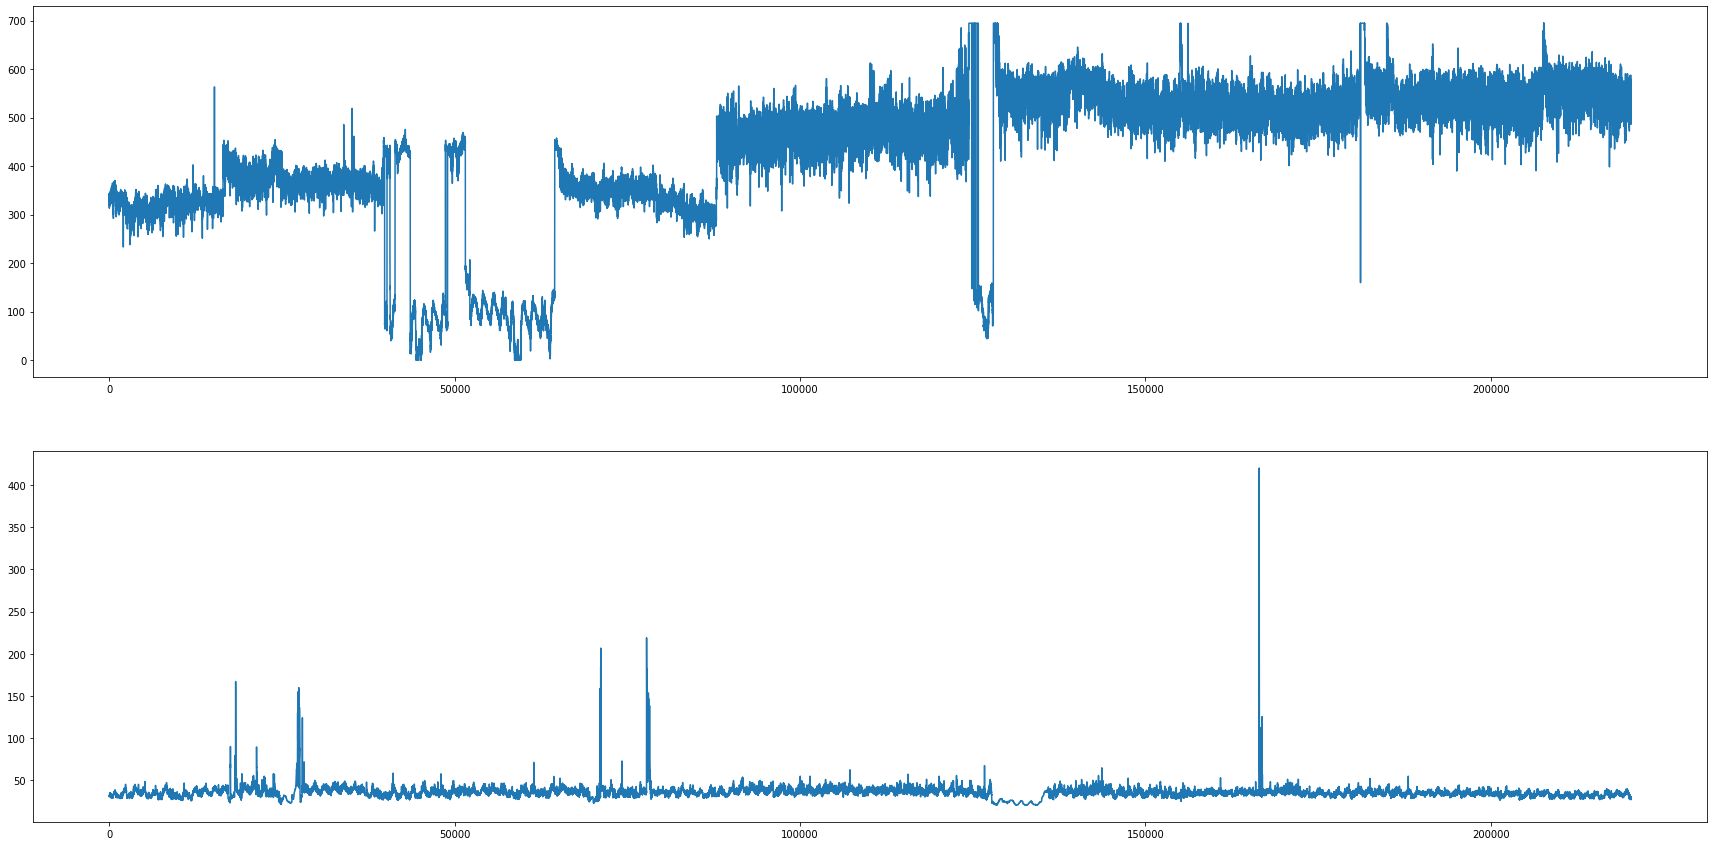

In [140]:
fig, axs = plt.subplots(2,figsize=(30,15))
# corr2=Df_motorProprieties.corr()
# corr2.style.background_gradient(cmap='coolwarm').set_precision(2)
# sns.heatmap(corr2, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
#             square=True, ax=ax)
x=range(0,220320,1)
axs[0].plot(x, Df_pumpFlow[Df_pumpFlow.columns[1]])
axs[1].plot(x, Df_bearingTemp[Df_bearingTemp.columns[1]])